# Exploratory Data Analysis

Below is the code for connecting to the database:

In [1]:
import pandas as pd
import psycopg2 as pg
import pandas.io.sql as psql
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import nltk
#from nltk.tokenize import RegexpTokenizer, word_tokenize
#from nltk.corpus import stopwords
#from collections import Counter
#from nltk.stem import PorterStemmer, WordNetLemmatizer
#from nltk.collocations import *
# Connect to database
def connect(host, database):
    connection = pg.connect('host={} dbname={}'.format(host, database))
    return connection

# Specify connection host and database
connection = connect('pg', 'jobs2018')

## Question: Is time_taken an useable field?

In [2]:
# Query sample from time_taken field
time_taken = psql.read_sql("SELECT time_taken FROM user_subset;", connection)

# Convert time_taken from milliseconds to minutes
time_taken['min'] = time_taken['time_taken']/1000/60

# Summarize new field
time_taken.describe()

,time_taken,min
count,5.872523e+07,5.872523e+07
mean,4.146095e+04,6.910158e-01
std,1.896015e+05,3.160024e+00
min,1.849000e+03,3.081667e-02
25%,2.250600e+04,3.751000e-01
50%,2.942900e+04,4.904833e-01
75%,4.149300e+04,6.915500e-01
max,4.498797e+07,7.497995e+02


We can see from above that the outliers are having a significant influence on the mean, etc. The following plots also illustrate this point.

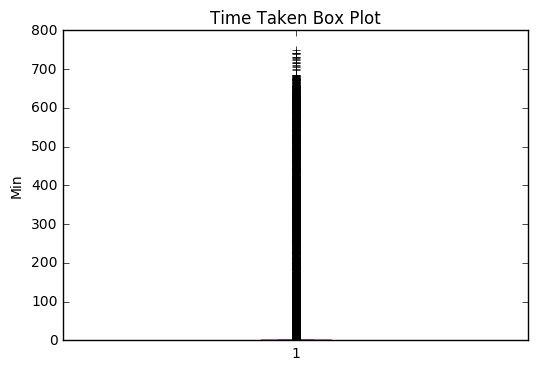

In [25]:
# Create box plot with outliers
plt.boxplot(time_taken['min'])
plt.title('Time Taken Box Plot')
plt.ylabel('Min')
plt.show()

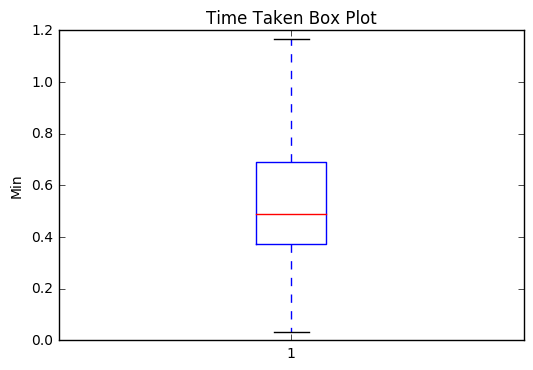

In [28]:
# Create box plot without outliers
plt.boxplot(time_taken['min'], 0, '')
plt.title('Time Taken Box Plot')
plt.ylabel('Min')
plt.show()

Note how skewed the histogram is below. It contains a tail on the right side of the histogram that extends to 700 minutes.

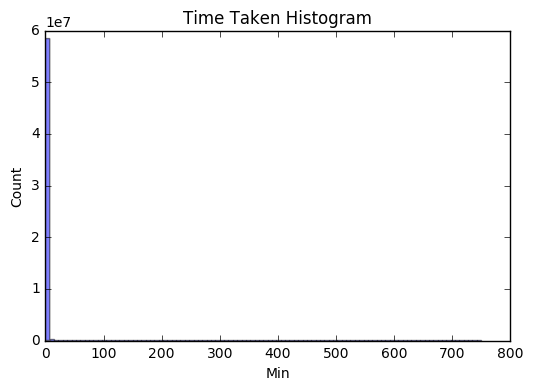

In [27]:
# Create histogram
plt.hist(time_taken['min'], 100, alpha = 0.5, facecolor = 'blue')
plt.title('Time Taken Histogram')
plt.xlabel('Min')
plt.ylabel('Count')
plt.show()

## Question: What is the trend in the number of users per day over time?

In [3]:
# Query aggregated table with click date and unique ip addresses
click_summary = psql.read_sql("SELECT click_date, COUNT(DISTINCT ip) as ip_count FROM user_click_old GROUP BY click_date;", connection)

The plot below shows an oscillating pattern in the number of IPs, which was our initial field to specify users. We can reasonably expect this from the number of users dropping on weekends, etc. However, we do see a very low IP count between December 2013 and February 2014. For our analysis, we may need to just use data from march 2014 to June 2014. Because of the limited number of months captured in the data, it's difficult to see any seasonality differences in the number of users per day.

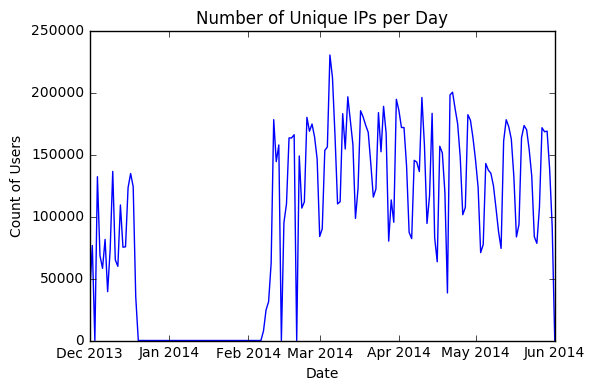

In [4]:
# Create a line graph using the data
plt.plot(click_summary['click_date'], click_summary['ip_count'])
plt.title('Number of Unique IPs per Day')
plt.xlabel('Date')
plt.ylabel('Count of Users')
plt.show()

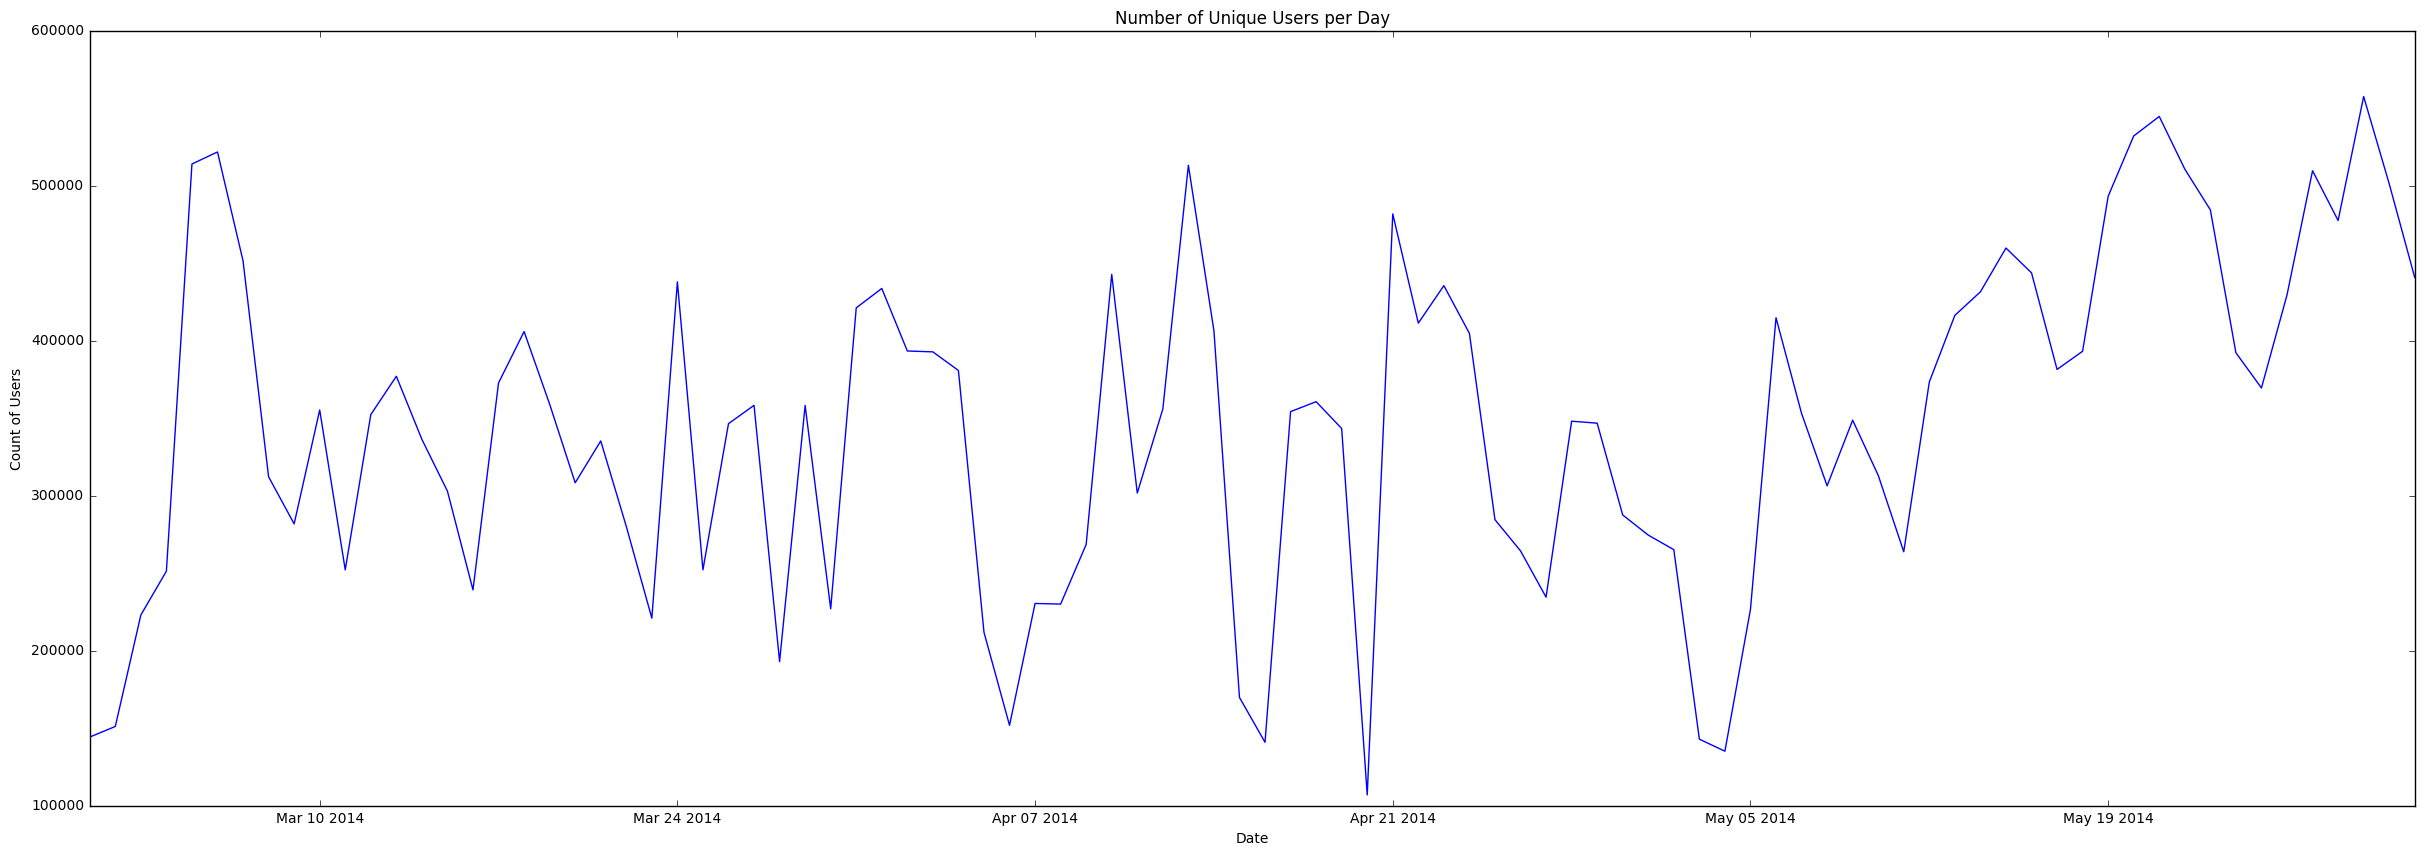

In [9]:
# Repeat above steps with data range from March to May 2014 and use aguid to specify users
click_summary = psql.read_sql("SELECT click_date, COUNT(DISTINCT aguid) as user_count FROM user_subset GROUP BY click_date;", connection)

plt.plot(click_summary['click_date'], click_summary['user_count'])
plt.title('Number of Unique Users per Day')
plt.xlabel('Date')
plt.ylabel('Count of Users')
plt.rcParams["figure.figsize"] = [300,100]
plt.show()

In [12]:
# Select all dates with less than 10 distinct users
click_summary[(click_summary['ip_count'] < 10)]

,click_date,ip_count
2,2013-12-03,5
19,2013-12-20,1
20,2013-12-21,1
21,2013-12-22,1
22,2013-12-23,1
23,2013-12-24,1
24,2013-12-25,1
25,2013-12-26,1
26,2013-12-27,1
27,2013-12-28,1


## Question: How many clicks come from registered users?

In [29]:
# Grab total number of clicks between March and May 2014
clicks = psql.read_sql("SELECT COUNT(*) FROM user_subset;", connection)
clicks

,count
0,58725228


In [30]:
# Grab total number of clicks by unregistered users
unregistered_clicks = psql.read_sql("SELECT COUNT(*) FROM user_subset WHERE aguid IS NULL;", connection)
unregistered_clicks

,count
0,9064229


In [31]:
# Calculate the percent of clicks from registered users
per_registered = 1 - (unregistered_clicks / clicks)
per_registered

,count
0,0.84565


In [32]:
# Grab number of distinct users
distinct_users = psql.read_sql("SELECT COUNT(DISTINCT aguid) FROM user_subset;", connection)
distinct_users

,count
0,27875416


## Question: How many users are return users (clicked on an ad on more than one day)?

In [33]:
# Create table for return users
return_users = psql.read_sql("SELECT aguid, COUNT(DISTINCT click_date) FROM user_subset GROUP BY aguid HAVING COUNT(DISTINCT click_date) > 1;", connection)
return_users

,aguid,count
0,0000034894b54e1ba91e5dacf75279be,2
1,00000c3ff0c64da1848feb0bc1a6a106,3
2,0000105e5c484bf5926aba0dd614bca0,4
3,00004ba85dab4375bdb969cd1be5a5b3,3
4,00004ebbdd434c3b9178a013a48304e5,2
5,000054b280504495a04e77290a0aeab4,3
6,00006106d9e04e3a9d1a36858accc23c,2
7,0000627b142648bc8f77cebd410fdf09,2
8,0000663ef1ca49ddbac60efa65551949,2
9,000066b974614b90bcdd89a90b10c950,3


## Question: How many jobs do a user look at in a typical day?

In [34]:
# Create clicks by user table 
clicks_by_user_day = psql.read_sql("SELECT click_date, ip, COUNT(*) FROM user_subset GROUP BY ip, click_date;", connection)
clicks_by_user_day

,click_date,ip,count
0,2014-05-31,100.0.0.123,3
1,2014-03-16,100.0.0.208,1
2,2014-04-03,100.0.0.208,1
3,2014-03-07,100.0.0.213,1
4,2014-03-10,100.0.0.213,2
5,2014-03-11,100.0.0.213,1
6,2014-03-13,100.0.0.213,3
7,2014-03-14,100.0.0.213,1
8,2014-03-19,100.0.0.213,1
9,2014-03-20,100.0.0.213,3


In [35]:
# Calculate average count by user per day
clicks_by_user_day["count"].mean()

4.538278111712692

## Question: Are job postings every posted multiple times?

In [3]:
uniquejobs = psql.read_sql("SELECT jvguid ,newdate, buid, jobtitle FROM jobposting;", connection)
uniquejobscount = uniquejobs.groupby(['buid', 'jobtitle']).nunique().drop('jobtitle',axis=1).drop('buid',axis=1).reset_index()
postedonce = uniquejobscount.loc[uniquejobscount['newdate']==1]
postedoncesum = postedonce['newdate'].sum()
postedtwice = uniquejobscount.loc[uniquejobscount['newdate']==2]
postedtwicesum = postedtwice['newdate'].sum()

This chart shows the number of aggregated number postings that were posted 'newdate' number of days.  For example the second row is 2, meaning that 419126 total postings were posted twice, leading to 419126/2 = 209563 unique postings posted twice. This is to show that the jobs re-posted more times have an impact on the distribution

In [8]:
uniquejobscount['sumpostings']=uniquejobscount['newdate']
uniquejobscount.groupby(['newdate']).sum()

,jvguid,sumpostings
newdate,,
1,1789927,1615585
2,522859,419126
3,252016,190701
4,164324,111508
5,100746,70885
6,70577,48324
7,55671,38381
8,47297,32192
9,43470,27441


Since most postings were posted either once or twice, I wanted to see the longer tail distribution in context so I excluded the first two

C:\Users\pchang\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


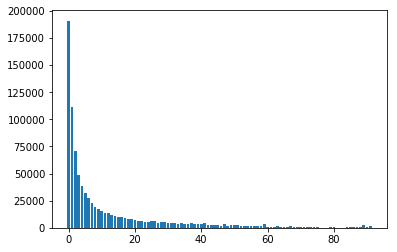

In [10]:
morethantwo = uniquejobscount.loc[uniquejobscount['newdate']>2]
morethantwo['sumdate'] = morethantwo['newdate']

jobsperbin = morethantwo[['sumdate','newdate']].groupby(['newdate']).sum().reset_index()
plt.bar(range(len(jobsperbin['sumdate'])),jobsperbin['sumdate'],align='center')
plt.show()

Now that we see that the longer tail has some influence, here the total number of jobs that were reposted over 50 times is less than 50,000, meaning they don't have too much representation.

In [11]:
morethan50 = morethantwo.loc[morethantwo['newdate']>50]
morethan50['newdate'].sum()

47690

Investigating outliers that reposted many times, we see that they were posted multiple days in a row, indicating either user error or intientional manipulation of the system

In [12]:
outliers = uniquejobscount.reset_index().sort_values(by='newdate',ascending=False).head()
outliers

,index,buid,jobtitle,jvguid,newdate,sumpostings
609334,609334,24747 ...,Electrical Engineer - Entry Level ...,436,94,94
1490391,1490391,287 ...,Customer Service Associate II ...,4894,94,94
609346,609346,24747 ...,Environmental Engineer - Mid Level ...,227,94,94
609342,609342,24747 ...,Engineering Intern ...,276,94,94
609356,609356,24747 ...,Instrumentaion & Controls Engineer - Entry Lev...,109,94,94


In [13]:
pd.merge(outliers, uniquejobs, how = 'left', left_on=['buid','jobtitle'], right_on = ['buid','jobtitle'])

,index,buid,jobtitle,jvguid_x,newdate_x,sumpostings,jvguid_y,newdate_y
0,609334,24747 ...,Electrical Engineer - Entry Level ...,436,94,94,56229380-6642-40D5-BD83-1E2EFB47E56C ...,2014-02-15
1,609334,24747 ...,Electrical Engineer - Entry Level ...,436,94,94,9E9B26B7-CBE9-4AC5-A632-D499A8CFB4BD ...,2014-02-15
2,609334,24747 ...,Electrical Engineer - Entry Level ...,436,94,94,DE4C8513-E172-4717-8EE3-5078EB08FFD6 ...,2014-02-15
3,609334,24747 ...,Electrical Engineer - Entry Level ...,436,94,94,9F5FDA93-9C4F-4EF3-8611-EFAAEDEA7B51 ...,2014-02-15
4,609334,24747 ...,Electrical Engineer - Entry Level ...,436,94,94,3D8DD206-23BE-4DA1-A264-F45267B01000 ...,2014-02-15
5,609334,24747 ...,Electrical Engineer - Entry Level ...,436,94,94,9094D433-3391-4CB7-90E9-22558BD9A618 ...,2014-02-16
6,609334,24747 ...,Electrical Engineer - Entry Level ...,436,94,94,D0F91804-8F41-469B-BA80-3DC8B1BA5CC0 ...,2014-02-16
7,609334,24747 ...,Electrical Engineer - Entry Level ...,436,94,94,FA93AB96-C2D5-4BB2-8860-4EBF18F633D1 ...,2014-02-16
8,609334,24747 ...,Electrical Engineer - Entry Level ...,436,94,94,DA4D2B93-6A0B-43D8-A14F-7375924776EE ...,2014-02-16
9,609334,24747 ...,Electrical Engineer - Entry Level ...,436,94,94,701C16CF-A3B0-49B9-9DC6-F47C4371D807 ...,2014-02-16


## Question: Are there any patterns in the length a job posting was online?

In [14]:
dates = psql.read_sql("SELECT jvguid ,newdate, expiredate, buid, jobtitle FROM jobposting;", connection)
dates['postlength'] = dates['expiredate'] - dates['newdate']
dates['postlengthfloat'] = dates['postlength'] / np.timedelta64(1, 'D')
dates.sort_values(by='postlength',ascending=False).head(5)

,jvguid,newdate,expiredate,buid,jobtitle,postlength,postlengthfloat
4199577,6011F83E-C557-4E81-BACE-C8564C61AF9F ...,2014-02-11,2014-06-09,1947 ...,Registered Nurse 3 ...,118 days,118.0
4237440,DCD32CB0-D31B-4DFA-B77D-2123C61174AF ...,2014-02-11,2014-06-09,7244 ...,Surgical Physicans Assistant ...,118 days,118.0
4179032,C58E45D0-5EC2-4E1F-91BE-4EAB0E505BE4 ...,2014-02-11,2014-06-09,207 ...,Cashier job in WASCO ...,118 days,118.0
4193273,400C4C8B-C2DA-4F73-9FE0-695520AE9059 ...,2014-02-11,2014-06-09,8316 ...,"3rd Shift Stocking Team Member - Royal Oak, MI...",118 days,118.0
4232967,52B4A1E5-9436-47C3-A7D6-C0DBFDFA3F6C ...,2014-02-11,2014-06-09,25923 ...,Field Compliance Manager ...,118 days,118.0


In [16]:
dates['postlengthfloat'].describe()

count    3.687740e+06
mean     2.029292e+01
std      1.918793e+01
min      0.000000e+00
25%      5.000000e+00
50%      1.500000e+01
75%      3.000000e+01
max      1.180000e+02
Name: postlengthfloat, dtype: float64

In [17]:
dates[['postlengthfloat','jvguid']].groupby(['postlengthfloat']).count().reset_index()

,postlengthfloat,jvguid
0,0.0,64839
1,1.0,297334
2,2.0,249547
3,3.0,146154
4,4.0,108716
5,5.0,116931
6,6.0,118197
7,7.0,126889
8,8.0,114135
9,9.0,88861


From this table we can see that most of the postings were posted for less than 20 days. What stood out was the postings that were posted 0-2 days, which could be mistakes. So to dig deeper, we looked at these postings to see if they were reposted. There were around 300,000 unique jobs that had postings last less than 3 days representing around 600,000 total job postings that were posted for less than 3 days

In [18]:
len(pd.DataFrame(dates.loc[dates['postlengthfloat']<3])[['buid','jobtitle']].drop_duplicates())

279968

In [19]:
len(pd.DataFrame(dates.loc[dates['postlengthfloat']<3])[['buid','jobtitle']])

611720

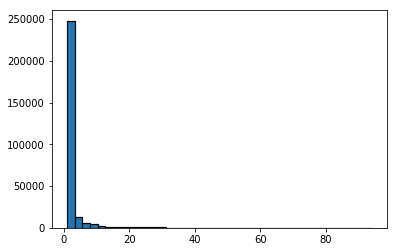

In [22]:
lessthanthree_jobs = pd.DataFrame(dates.loc[dates['postlengthfloat']<3])[['buid','jobtitle']].drop_duplicates()
lessthanthree=pd.merge(lessthanthree_jobs, uniquejobscount, how = 'left', left_on=['buid','jobtitle'], right_on = ['buid','jobtitle'])
lessthanthree = lessthanthree[np.isfinite(lessthanthree['newdate'])]
plt.hist(lessthanthree['newdate'], bins = 40,edgecolor='black', linewidth=1.2)
plt.show()

As we can see from the table and histogram, most of the postings that were posted less than 3 times were reposted only once, implying mistakes

In [24]:
lessthanthree.groupby(['newdate']).count().head(15)

,buid,jobtitle,jvguid,sumpostings
newdate,,,,
1.0,194976,194976,194976,194976
2.0,36739,36739,36739,36739
3.0,16281,16281,16281,16281
4.0,8039,8039,8039,8039
5.0,4444,4444,4444,4444
6.0,2934,2934,2934,2934
7.0,2240,2240,2240,2240
8.0,1743,1743,1743,1743
9.0,1440,1440,1440,1440


## Question: What are the most popular data tools in the job requirements?

java115444 python27737 javascript52019 sql145657 tableau4194 matlab9096 scala168476 hadoop8689


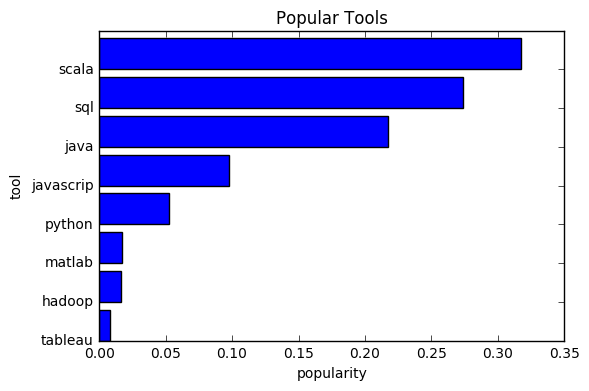

In [5]:
# pull all descriptions 
alldesc= psql.read_sql("SELECT description FROM jobposting;", connection)

# initialize counter
java,python,javascript,sql,tableau,matlab,scala,hadoop=[0 for i in range(8)]

# count frequency of each word
for i in alldesc['description']:
    if i!=None:
        desc = i.upper()
        if 'JAVA' in desc:
            java+=1
        if 'PYTHON' in desc:
            python+=1
        if 'JAVASCRIPT' in desc:
            javascript+=1
        if 'SQL' in desc:
            sql+=1
        if 'TABLEAU' in desc:
            tableau+=1
        if 'MATLAB' in i.upper():
            matlab+=1
        if 'SCALA' in i.upper():
            scala+=1
        if 'HADOOP' in i.upper():
            hadoop+=1
            
# print results
print("java{} python{} javascript{} sql{} tableau{} matlab{} scala{} hadoop{}".
      format(java,python,javascript,sql,tableau,matlab,scala,hadoop))

# plot bar chart
types = {"java":java,"python":python,"javascrip":javascript,"sql":sql,"tableau":tableau,"matlab":matlab,"scala":scala,"hadoop":hadoop}
top_types = sorted(types,key=types.__getitem__,reverse = True)
top_occur = [types[top_types[i]]/float(sum(types.values())) for i in range(len(types))]
plt.barh(range(1,9),list(reversed(top_occur)))
plt.yticks(range(1,9), list(reversed(top_types)))
plt.title('Popular Tools')
plt.xlabel('popularity')
plt.ylabel('tool')
plt.show()

## Question: Are some locations more popular than others for specific fields?

In [6]:
import csv

# list of all U.S. states
states = ["AL", "AK", "AZ", "AR", "CA", "CO", "CT", "DC", "DE", "FL", "GA", 
          "HI", "ID", "IL", "IN", "IA", "KS", "KY", "LA", "ME", "MD", 
          "MA", "MI", "MN", "MS", "MO", "MT", "NE", "NV", "NH", "NJ", 
          "NM", "NY", "NC", "ND", "OH", "OK", "OR", "PA", "RI", "SC", 
          "SD", "TN", "TX", "UT", "VT", "VA", "WA", "WV", "WI", "WY"]

# extract the state in location, excluding Hawaii and Canada
def extract_state(location):
     global states
     if location==None:
          return(location)
     else:
          match = next((s for s in states if s in location), False)
          if match:
               return(match)
          else:
               return('Canada/Hawaii')

# subset software positions
soft_loc=psql.read_sql("SELECT loc FROM jobposting WHERE software=TRUE;", connection)

# count frequencies of states
soft_state = [extract_state(l) for l in soft_loc['loc']]
soft_counts =collections.Counter(soft_state)
print(soft_counts)

# write to csv for Tableau plots
with open('dict_soft.csv','w') as csvfile:
    writer=csv.writer(csvfile)
    for key,value in soft_counts.items():
        writer.writerow([key] + [value]) 

Counter({'CA': 9124, 'UNKNOWN': 8175, 'WA': 3302, 'IN': 3279, 'TX': 2522, 'VA': 2467, 'MI': 2408, 'MA': 2370, 'MD': 2063, 'CO': 1897, 'NY': 1888, 'GA': 1382, 'PA': 1247, 'FL': 1169, 'IL': 1135, 'MN': 1075, 'NJ': 1031, 'CT': 901, 'NC': 807, 'ME': 803, 'AL': 773, 'OR': 767, 'AZ': 695, 'OH': 664, 'MO': 512, 'UT': 427, 'AR': 409, 'DE': 387, 'NE': 377, 'DC': 368, 'NH': 279, 'IA': 269, 'WI': 244, 'LA': 200, 'TN': 193, 'KS': 187, 'RI': 173, 'OK': 162, 'AK': 153, 'NM': 144, 'NV': 128, 'SC': 126, 'ID': 123, 'KY': 111, 'HI': 106, 'WV': 103, 'ND': 90, 'VT': 57, 'MT': 55, 'MS': 51, 'SD': 45, 'WY': 12, None: 1})


In [7]:
# same for finance positions
finance_loc=psql.read_sql("SELECT loc FROM jobposting WHERE finance=TRUE;", connection)
finance_state = [extract_state(l) for l in finance_loc['loc']]
finance_counts =collections.Counter(finance_state)
print(finance_counts)
with open('dict_finance.csv','w') as csvfile:
    writer=csv.writer(csvfile)
    for key,value in finance_counts.items():
        writer.writerow([key] + [value]) 

Counter({'UNKNOWN': 9226, 'CA': 5462, 'ME': 5157, 'NY': 5067, 'TX': 3345, 'IL': 2877, 'MI': 2597, 'FL': 2370, 'NJ': 2345, 'GA': 2320, 'MA': 2032, 'PA': 1948, 'IN': 1872, 'NC': 1721, 'MN': 1682, 'VA': 1658, 'MO': 1448, 'OH': 1410, 'CO': 1280, 'CT': 1237, 'AL': 1139, 'WA': 1099, 'MD': 1097, 'AZ': 1044, 'DC': 953, 'TN': 866, 'AR': 861, 'DE': 642, 'OR': 621, 'WI': 569, 'NE': 488, 'LA': 464, 'SC': 432, 'KS': 420, 'IA': 419, 'OK': 401, 'UT': 375, 'KY': 300, 'ID': 250, 'NV': 237, 'AK': 237, 'MS': 227, 'NH': 211, 'RI': 205, 'HI': 158, 'ND': 146, 'WV': 131, 'NM': 130, 'SD': 76, 'MT': 59, 'WY': 56, 'VT': 39, None: 1})


## Question: What are the most common referrers

In [ ]:
import collections

# count frequency of each referrer
refers = psql.read_sql("SELECT refer FROM user_click_old", connection)
counter=collections.Counter(refers['refer'])

# select the top 10 
print(counter.most_common(10))

## Question: Is there any difference in education requirement for different job types

In [ ]:
# get job descriptions for research positions
descres =  psql.read_sql("SELECT description FROM jobposting WHERE research=TRUE ", connection)

# initialize counter
bachelor, masters, phd = [0 for i in range(3)]
count=0

# counts of each category
for i in descres['description']:
    if i!=None:
        desc = i.upper()
        if 'BACHELOR' in desc or 'B.S' in desc or 'B.A' in desc:
            bachelor+=1
        if 'MASTERS' in desc or 'M.S' in desc or 'MBA' in desc or 'M.A' in desc:
            masters+=1
        if 'PHD' in desc or 'PH.D' in desc:
            phd+=1
    count+=1;

# get proportions by dividing total
print(bachelor/count,masters/count,phd/count)

In [ ]:
# get job descriptions for operation positions
descopr =  psql.read_sql("SELECT description FROM jobposting WHERE operation=TRUE ", connection)

# initialize counter
bachelor, masters, phd = [0 for i in range(3)]
count=0

# counts of each category
for i in descopr['description']:
    if i!=None:
        desc = i.upper()
        if 'BACHELOR' in desc or 'B.S' in desc or 'B.A' in desc:
            bachelor+=1
        if 'MASTERS' in desc or 'M.S' in desc or 'MBA' in desc or 'M.A' in desc:
            masters+=1
        if 'PHD' in desc or 'PH.D' in desc:
            phd+=1
    count+=1;
    
# get proportions by dividing total
print(bachelor/count,masters/count,phd/count)

## Try to find frequency of words and phrases in job descriptions

In [27]:
#dataframe of subset of job descriptions
df_jobs_desc = psql.read_sql("SELECT description FROM jobposting LIMIT 100000;", connection) 

In [28]:
#number of jobs with empty descriptions in dataframe
t = 0
for desc in df_jobs_desc['description'].tolist():
    try:
        tokens = word_tokenize(desc)
    except:
        t+=1
print(t)

0


In [ ]:
#convert empty job descriptions
df_jobs_desc['description'] = ['na' if x is np.nan else x for x in df_jobs_desc['description']]

In [30]:
#top N words
N = 100
#ignore stopwords from calculations
stopwords = nltk.corpus.stopwords.words('english')
# RegEx for stopwords
RE_stopwords = r'\b(?:#-{})\b'.format('|'.join(stopwords))
# replace '|\' to ' ' and drop all stopwords
words = (df_jobs_desc.description
           .str.lower()
           .replace([r'\|', RE_stopwords], [' ', ''], regex=True)
           .str.cat(sep=' ')
           .split())
#lemmatise words
lemmatizer = WordNetLemmatizer()
words_lemm = [lemmatizer.lemmatize(w) for w in words]
#find top n words with frequency
rslt = pd.DataFrame(Counter(words_lemm).most_common(N), columns=['Word', 'Frequency']).set_index('Word')
print(rslt)


                Frequency
Word                     
customer           211084
work               204899
service            176396
experience         155679
*                  153602
ability            145884
-                  130453
business           110181
sale               106993
product            104632
team               102329
must                99509
job                 93411
skill               87223
management          85101
/                   81332
company             81208
position            81088
opportunity         80874
year                76286
including           75019
knowledge           74818
support             73799
store               73576
system              65559
process             61106
&                   60484
project             60163
information         57866
able                57533
...                   ...
environment         37896
equipment           37410
responsibility      37289
school              37191
plan                36816
requirement 

In [34]:
#top 5 three word phrases
trigram_measures = nltk.collocations.TrigramAssocMeasures()
finder = TrigramCollocationFinder.from_words(words)
finder.apply_freq_filter(3)
print(finder.nbest(trigram_measures.pmi, 5)) 


[('$10.50picker/packer:', '$10.50shift:', 'mon-fridayworking'), ('$11.00stockers:', '$10.50picker/packer:', '$10.50shift:'), ('&#8220;practical', 'minor&#8221;', 'journalism.*'), ('&amp;nbsp;thanks', 'achala080', '26254318&amp;nbsp;'), ("&b;'", 'eram', 'softwarefunctional')]


In [25]:
#top 5 two word phrases
bigram_measures = nltk.collocations.BigramAssocMeasures()
finder = BigramCollocationFinder.from_words(words)
print(finder.nbest(bigram_measures.pmi, 5)) 

[('"know', 'customer"'), ('"orally"', 'expressively'), ('#:', '3830#'), ('#:5968', 'location:toledo'), ('#:5969', 'location:mclean')]


## Analysing trends about how long jobs are posted online

In [66]:
#creating jobs dataframe
df_jobs = psql.read_sql("SELECT jvguid, newdate, company, jobtitle, expiredate FROM jobposting;", connection) 

In [ ]:
#column to measure how long a job posting stayed online
df_jobs["timediff"] = df_jobs["expiredate"]-df_jobs["newdate"] 
df_jobs["timediff"] = df_jobs["timediff"].dt.days  


In [53]:
#caluclating length of job posting grouped by job title
timediff_jobtitle = df_jobs.groupby('jobtitle', as_index=False)['timediff'].mean()
timediff_jobtitle = timediff_jobtitle.sort('timediff', ascending=False)


/opt/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:2: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  from ipykernel import kernelapp as app


In [55]:
#number of jobs that were never removed
nas = len(df_jobs[df_jobs['timediff'].isnull()])
nas 

1090851

In [56]:
#average job title takes 20.2 days to fill
timediff_jobtitle["timediff"].describe() 

count    1.118366e+06
mean     2.019338e+01
std      1.657513e+01
min      0.000000e+00
25%      7.000000e+00
50%      1.650000e+01
75%      3.000000e+01
max      1.180000e+02
Name: timediff, dtype: float64

In [18]:
#jobtitles that took longest to expire
slowest_jobtitle = timediff_jobtitle.head(10000)
slowest_jobtitle 

,jobtitle,timediff
1067856,Registered Nurse / OR / Per Diem / 1st & 2nd S...,118.0
500636,Field Compliance Manager ...,118.0
1065429,Registered Nurse - Med/Surg - Per Diem ...,116.0
64945,Activities Associate(Seasonal) - Kingsgate Res...,116.0
747862,Management Consulting Operations Retail Direct...,116.0
1289550,Sr.BusinessIntelligenceAnalyst ...,116.0
1131167,SR. Staff Engineer- System Architect ...,116.0
1109614,Roboter-Inbetriebnehmer Prozessteacher (m/w) ...,116.0
656973,"Intern, SharePoint - Information Technology, W...",116.0
842575,ORGANIZATIONAL CHANGE MANAGEMENT SPECIALIST ...,116.0


In [29]:
#Zero represents jobs postings that closed the same day. This is not intuitive and we cannot assume expiry=position filled.
timediff_jobtitle = timediff_jobtitle.dropna()
fastest_jobtitle = timediff_jobtitle.tail(10000)

,jobtitle,timediff
560463,Gerente de engorda de ganado ...,0.0
428593,EMPRESA AZULEJERA SOLICITA JEFA DE OFICINA/E ...,0.0
1413457,Urge Desarrollador J2EE (León) ...,0.0
1076270,"Relaciones Públicas- Ingreso $15,000 +3,000 bo...",0.0
163239,Becario Manufactura - Cuautitlan Izcalli ...,0.0
560468,Gerente de farmacoeconomiay negociacion con la...,0.0
1413459,Urge Ejecutiva Administraiva !!!!! ...,0.0
731344,MECANICOS EN MAQUINARIA PESADA PUEBLA Recién e...,0.0
1413460,Urge Ejecutiva de Atencion a Clientes !!!!! ...,0.0
850830,Oil Spill Cleanup ...,0.0


In [30]:
#number of jobs postings closed the same day
jobtitle_zerodiff = len(timediff_jobtitle[timediff_jobtitle['timediff']==0])
jobtitle_zerodiff 

10193

## Job titles featured most in job postings

In [16]:
#Most popular 10000 job titles featured in job postings 
jobtitles_10000 = df_jobs['jobtitle'].value_counts().head(10000)
jobtitles_10000 = list(jobtitles_10000.keys())
jobtitles_10000[:25] 

['Store Seasonal Employee                                                                                                                                                                                                                                        ',
 'Shift Supervisor Trainee                                                                                                                                                                                                                                       ',
 'Customer Service Representative                                                                                                                                                                                                                                ',
 'Restaurant Crew                                                                                                                                                                                                           

In [33]:
#checking if there is difference in length of time jobs are kept online for the top 10000 most posted jobs
timediff_10000_jobtitles = timediff_jobtitle[timediff_jobtitle['jobtitle'].isin(jobtitles_10000)]
timediff_10000_jobtitles['timediff'].describe()  

count    10000.000000
mean        21.248248
std         17.634655
min          0.000000
25%         13.390608
50%         21.003772
75%         25.864688
max        150.000000
Name: timediff, dtype: float64

In [ ]:
#average company takes 25 days to close one of it's job opening
timediff_company = df_jobs.groupby('company', as_index=False)['timediff'].mean()  

In [37]:
#companies that have job postings open for the longest duration
timediff_company = timediff_company.sort('timediff', ascending=False)
slowest_company = timediff_company.head(10000)
slowest_company 

/opt/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  if __name__ == '__main__':


,company,timediff
32267,Family Home Medical ...,112.0
57098,Maximum Security Systems/Specialized Security ...,110.0
29983,Encore Staffing ...,109.0
21915,Continental Carbon ...,109.0
44402,International Waxes ...,108.0
56682,Marty Joiner - State Farm Agent ...,108.0
52344,LifeStar Response Corporation ...,108.0
55699,Magic Valley Heli-Arc & Mfg. ...,108.0
87105,The Douglas Center ...,107.0
21186,"Communications Center, Inc. ...",107.0


In [38]:
slowest_company.describe()

,timediff
count,10000.000000
mean,51.750756
std,11.653146
min,37.500000
25%,42.400000
50%,49.000000
75%,60.000000
max,112.000000


In [44]:
#companies that close their postings the fastest
timediff_company = timediff_company.dropna()
fastest_company = timediff_company.tail(10000)
fastest_company 

,company,timediff
47913,KNOLL CONSTRUCTION ...,11.0
69684,Prestige Paving ...,11.0
69138,Portage County Human Resources ...,11.0
69691,Presto Products Company ...,11.0
16850,Caesars Entertainment Operating Company ...,11.0
14387,CARLSON BROS PLUMBING AND HEATING ...,11.0
96627,Wolf Lodge Inn. LLC ...,11.0
62437,Newport News Behavioral Health ...,11.0
94337,WINJUM'S SHADY ACRES OF FARIBAULT ...,11.0
64199,Oceus Networks ...,11.0


In [45]:
fastest_company.describe()

,timediff
count,10000.000000
mean,5.987681
std,2.922144
min,0.000000
25%,4.000000
50%,6.000000
75%,8.428756
max,11.000000


## Companies that post maximum jobs in the portal

In [15]:
 #companies that post maximum jobs on the portal
company_10000 = df_jobs['company'].value_counts().head(10000)
company_10000 = list(company_10000.keys())
company_10000[:25]

['OCCMundial                                                                                                                                                                                                                                                     ',
 'Soliant Health                                                                                                                                                                                                                                                 ',
 'Hy-Vee Food Stores                                                                                                                                                                                                                                             ',
 "Lowe's                                                                                                                                                                                                                    

In [36]:
#companies which are most active in the portal take 24 days to fill their openings
timediff_10000_company = timediff_company[timediff_company['company'].isin(company_10000)]
timediff_10000_company['timediff'].describe() 

count    9674.000000
mean       24.374757
std         9.430825
min         0.000000
25%        18.666667
50%        23.960176
75%        29.402158
max        98.000000
Name: timediff, dtype: float64

In [67]:
#users dataframe
df_users =  psql.read_sql("SELECT aguid, jvguid, time_taken FROM user_subset;", connection) 

In [68]:
#to make jvguid column similar in both tables
df_jobs['jvguid'] = df_jobs['jvguid'].str.lower().str.replace("-","").str.strip() 

In [69]:
#merging dataframes
df_users_jobs = df_users.merge( df_jobs, how='inner', on = ['jvguid']) 

In [70]:
del df_jobs

In [71]:
del df_users

## Jobs Titles that are most popular among users

In [72]:
# job titles which have the most clicks 
users_jobtitle = df_users_jobs.groupby('jobtitle', as_index=False)['aguid'].agg('count')
jobtitle_10000 = users_jobtitle.sort_values('aguid', ascending=False).head(10000)
jobtitle_1000 = users_jobtitle.sort_values('aguid', ascending=False).head(1000)
jobtitle_500 = users_jobtitle.sort_values('aguid', ascending=False).head(500)
jobtitle_100 = users_jobtitle.sort_values('aguid', ascending=False).head(100)
jobtitle_10 = users_jobtitle.sort_values('aguid', ascending=False).head(10)

In [73]:
#job titles which are most popular among users
jobtitle_10000 

,jobtitle,aguid
41943,Administrative Assistant ...,219178
239051,Customer Service Representative ...,178426
837137,Security Officer ...,130982
880589,Shift Supervisor Trainee ...,127350
812524,Sales Associate ...,106399
742803,Receptionist ...,97618
233028,Customer Care Assistant ...,87957
932776,Store Seasonal Employee ...,85586
738368,RURAL CARR ASSOC/SRV REG RTE ...,71111
702581,Project Manager ...,67706


In [75]:
#average jobtitle gets hits from 40 users
users_jobtitle['aguid'].describe() 

count    1.044254e+06
mean     3.916281e+01
std      5.367393e+02
min      0.000000e+00
25%      3.000000e+00
50%      9.000000e+00
75%      2.500000e+01
max      2.191780e+05
Name: aguid, dtype: float64

In [76]:
#10000 most popular jobtitles get an average of hits from 1700 users
jobtitle_10000['aguid'].describe() 

count     10000.000000
mean       1695.747100
std        5209.674122
min         385.000000
25%         484.000000
50%         681.000000
75%        1275.000000
max      219178.000000
Name: aguid, dtype: float64

In [77]:
#1000 most popular jobtitles get an average of hits from 10000 users
jobtitle_1000['aguid'].describe() 

count      1000.000000
mean       9387.143000
std       14256.581577
min        2903.000000
25%        3728.500000
50%        5180.500000
75%        9636.000000
max      219178.000000
Name: aguid, dtype: float64

In [78]:
#100 most popular jobtitles get an average of hits from 38000 users
jobtitle_100['aguid'].describe() 

count       100.000000
mean      37906.860000
std       31980.037282
min       18668.000000
25%       21548.250000
50%       25913.000000
75%       39719.250000
max      219178.000000
Name: aguid, dtype: float64

In [80]:
#10 most popular jobtitles get an average of hits from 117000 users
jobtitle_10['aguid'].describe() 

count        10.000000
mean     117231.300000
std       48727.881722
min       67706.000000
25%       86178.750000
50%      102008.500000
75%      130074.000000
max      219178.000000
Name: aguid, dtype: float64

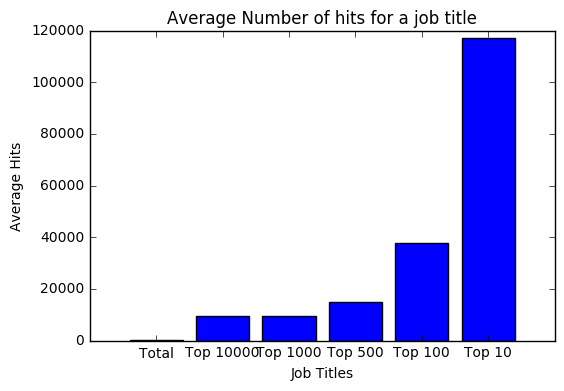

In [81]:
#graph to visualise average hits by user on job title vis-a-vis popularity of job title
hello = [users_jobtitle['aguid'].mean(), jobtitle_1000['aguid'].mean(), jobtitle_1000['aguid'].mean(), jobtitle_500['aguid'].mean(), jobtitle_100['aguid'].mean(), jobtitle_10['aguid'].mean()]
hi = [1,2,3,4,5, 6]
label = ['Total', 'Top 10000', 'Top 1000', 'Top 500', 'Top 100', 'Top 10']
plt.bar(hi, hello, align = 'center')
plt.xlabel('Job Titles')
plt.xticks(hi, label)
plt.ylabel('Average Hits')
plt.title("Average Number of hits for a job title")
plt.show() 

## Companies that are most popular among users

In [82]:
#most popular companies on the basis of user clicks
users_company =  df_users_jobs.groupby('company', as_index=False)['aguid'].count()
company_10000 = users_company.sort_values('aguid', ascending=False).head(10000) #most popular companies among users
company_1000 = users_company.sort_values('aguid', ascending=False).head(1000) #most popular companies among users
company_100 = users_company.sort_values('aguid', ascending=False).head(100) #most popular companies among users
company_500 = users_company.sort_values('aguid', ascending=False).head(500) #most popular companies among users
company_10 = users_company.sort_values('aguid', ascending=False).head(10) #most popular companies among users
company_10000

,company,aguid
70305,Xerox ...,1164821
38585,Lowe's ...,758609
35245,Kelly Services ...,435461
3277,Aetna ...,429479
57061,Sears Holdings ...,399112
66832,VMware ...,375875
70212,Wyndham Worldwide ...,326867
26158,General Electric ...,288389
941,ADP ...,275672
40647,Manpower Group ...,258672


In [83]:
#on average, a company gets hits from 575 users
users_company['aguid'].describe() 

count    7.119300e+04
mean     5.744393e+02
std      8.431124e+03
min      0.000000e+00
25%      2.000000e+00
50%      8.000000e+00
75%      4.200000e+01
max      1.164821e+06
Name: aguid, dtype: float64

In [85]:
#most popular 1000 companies gets hits from 32000 users
company_1000['aguid'].describe() 

count    1.000000e+03
mean     3.251747e+04
std      6.335438e+04
min      5.798000e+03
25%      8.898500e+03
50%      1.471050e+04
75%      3.246950e+04
max      1.164821e+06
Name: aguid, dtype: float64

In [86]:
#most popular 100 companies gets hits from 150000 users
company_100['aguid'].describe() 

count    1.000000e+02
mean     1.566531e+05
std      1.463816e+05
min      6.410800e+04
25%      7.629100e+04
50%      1.119390e+05
75%      1.941122e+05
max      1.164821e+06
Name: aguid, dtype: float64

In [87]:
#most popular 500 companies gets hits from 50000 users
company_500['aguid'].describe() 

count    5.000000e+02
mean     5.583447e+04
std      8.330815e+04
min      1.474100e+04
25%      2.141850e+04
50%      3.250200e+04
75%      5.655250e+04
max      1.164821e+06
Name: aguid, dtype: float64

In [88]:
#most popular 10 companies gets hits from 470000 users
company_10['aguid'].describe() 

count    1.000000e+01
mean     4.712957e+05
std      2.825807e+05
min      2.586720e+05
25%      2.980085e+05
50%      3.874935e+05
75%      4.339655e+05
max      1.164821e+06
Name: aguid, dtype: float64

In [89]:
#most popular 10000 companies gets hits from 4000 users
company_10000['aguid'].describe() 

count    1.000000e+04
mean     3.988771e+03
std      2.219331e+04
min      1.190000e+02
25%      1.930000e+02
50%      3.980000e+02
75%      1.444250e+03
max      1.164821e+06
Name: aguid, dtype: float64

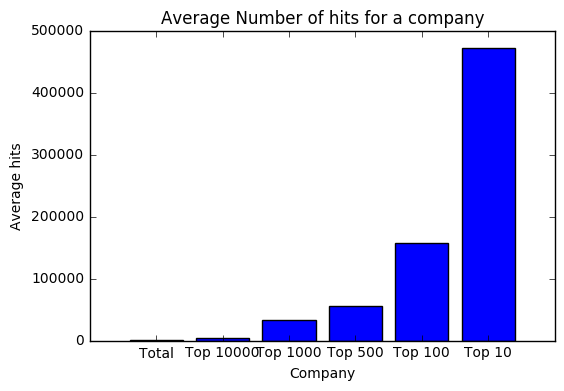

In [91]:
#graph to visualise average hits by user on company vis-a-vis popularity of company
hello = [users_company['aguid'].mean(), company_10000['aguid'].mean(), company_1000['aguid'].mean(), company_500['aguid'].mean(), company_100['aguid'].mean(), company_10['aguid'].mean()]
hi = [1,2,3,4,5, 6]
label = ['Total', 'Top 10000', 'Top 1000', 'Top 500', 'Top 100', 'Top 10']
#plt.plot(hi, hello, 'b')
plt.bar(hi, hello, align='center')
plt.xlabel('Company')
plt.xticks(hi, label)
plt.ylabel('Average hits')
plt.title("Average Number of hits for a company")
plt.show() 


## Trends on time spent by a user on a job posting

In [93]:
#convert to minutes
df_users_jobs["time_taken"] = df_users_jobs['time_taken']/1000/60 

In [94]:
#average user spends around 45 seconds on a job
df_users_jobs["time_taken"].describe() 

count    4.202007e+07
mean     7.254856e-01
std      3.510563e+00
min      3.081667e-02
25%      4.020667e-01
50%      5.173833e-01
75%      6.939667e-01
max      7.497995e+02
Name: time_taken, dtype: float64

In [96]:
 #compared to an average job, user spends a little more time on a job from popular company
timetaken_company = df_users_jobs.groupby('company', as_index=False)['time_taken'].mean()
timetaken_company = timetaken_company.sort_values('time_taken', ascending=False)
timetaken_10000_company = timetaken_company[timetaken_company['company'].isin(company_10000['company'])]
timetaken_10000_company['time_taken'].describe()

count    10000.000000
mean         0.759776
std          0.253125
min          0.118345
25%          0.620863
50%          0.723982
75%          0.845624
max          5.748074
Name: time_taken, dtype: float64

In [97]:
#compared to an average job, user spends a little more time on a job from popular company
timetaken_1000_company = timetaken_company[timetaken_company['company'].isin(company_1000['company'])]
timetaken_1000_company['time_taken'].describe() 

count    1000.000000
mean        0.753710
std         0.142899
min         0.422907
25%         0.647550
50%         0.734245
75%         0.851485
max         1.427392
Name: time_taken, dtype: float64

In [98]:
#compared to an average job, user spends a little more time on a job from popular company
timetaken_500_company = timetaken_company[timetaken_company['company'].isin(company_500['company'])]
timetaken_500_company['time_taken'].describe() 

count    500.000000
mean       0.728708
std        0.135136
min        0.422907
25%        0.634370
50%        0.700205
75%        0.819473
max        1.175919
Name: time_taken, dtype: float64

In [99]:
#compared to an average job, user spends less time on a job from popular company, seems counter intuitive
timetaken_100_company = timetaken_company[timetaken_company['company'].isin(company_100['company'])]
timetaken_100_company['time_taken'].describe() 

count    100.000000
mean       0.694926
std        0.137307
min        0.481605
25%        0.604459
50%        0.658959
75%        0.755738
max        1.171118
Name: time_taken, dtype: float64

In [100]:
#compared to an average job, user spends less time on a job from popular company, seems counter intuitive
timetaken_10_company = timetaken_company[timetaken_company['company'].isin(company_10['company'])]
timetaken_10_company['time_taken'].describe() 

count    10.000000
mean      0.650385
std       0.115401
min       0.494165
25%       0.572369
50%       0.613697
75%       0.710325
max       0.855133
Name: time_taken, dtype: float64

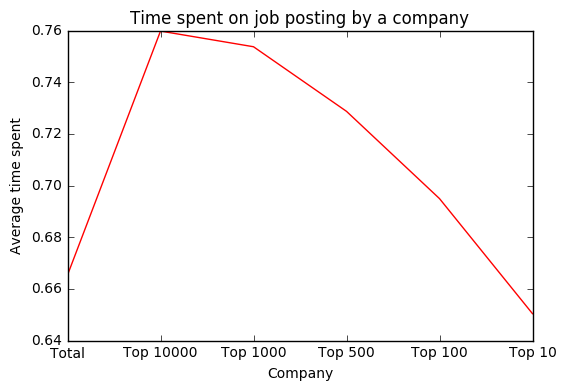

In [101]:
#graph to visualise time taken by user on job posting vis-a-vis popularity of company posting job
hello = [timetaken_company['time_taken'].mean(), timetaken_10000_company['time_taken'].mean(), timetaken_1000_company['time_taken'].mean(), timetaken_500_company['time_taken'].mean(), timetaken_100_company['time_taken'].mean(), timetaken_10_company['time_taken'].mean()] 
hi = [1,2,3,4,5,6]
label = ['Total', 'Top 10000', 'Top 1000', 'Top 500', 'Top 100', 'Top 10']
plt.plot(hi, hello, 'r')
#plt.bar(hi, hello, align='center')
plt.xlabel('Company')
plt.xticks(hi, label)
plt.ylabel('Average time spent')
plt.title("Time spent on job posting by a company")
plt.show() 


In [103]:
#compared to an average job, user spends a little less time on a popular job which is surprising
timetaken_jobtitle = df_users_jobs.groupby('jobtitle', as_index=False)['time_taken'].mean()
timetaken_jobtitle = timetaken_jobtitle.sort_values('time_taken', ascending=False)
timetaken_10000_jobtitle = timetaken_jobtitle[timetaken_jobtitle['jobtitle'].isin(jobtitle_10000['jobtitle'])]
timetaken_10000_jobtitle['time_taken'].describe()

count    10000.000000
mean         0.693188
std          0.235425
min          0.393270
25%          0.590522
50%          0.668160
75%          0.750401
max          9.233744
Name: time_taken, dtype: float64

In [104]:
#compared to an average job, user spends a little less time on a popular job which is surprising
timetaken_1000_jobtitle = timetaken_jobtitle[timetaken_jobtitle['jobtitle'].isin(jobtitle_1000['jobtitle'])]
timetaken_1000_jobtitle['time_taken'].describe()

count    1000.000000
mean        0.680087
std         0.110959
min         0.425953
25%         0.615837
50%         0.674483
75%         0.734198
max         1.302202
Name: time_taken, dtype: float64

In [105]:
#compared to an average job, user spends a little less time on a popular job which is surprising
timetaken_100_jobtitle = timetaken_jobtitle[timetaken_jobtitle['jobtitle'].isin(jobtitle_100['jobtitle'])]
timetaken_100_jobtitle['time_taken'].describe()

count    100.000000
mean       0.679090
std        0.080043
min        0.488723
25%        0.632717
50%        0.674720
75%        0.723649
max        0.984678
Name: time_taken, dtype: float64

In [106]:
#compared to an average job, user spends a little less time on a popular job which is surprising
timetaken_500_jobtitle = timetaken_jobtitle[timetaken_jobtitle['jobtitle'].isin(jobtitle_500['jobtitle'])]
timetaken_500_jobtitle['time_taken'].describe()

count    500.000000
mean       0.676231
std        0.099561
min        0.445129
25%        0.618805
50%        0.674720
75%        0.729619
max        1.302202
Name: time_taken, dtype: float64

In [107]:
#compared to an average job, user spends a little less time on a popular job which is surprising
timetaken_10_jobtitle = timetaken_jobtitle[timetaken_jobtitle['jobtitle'].isin(jobtitle_10['jobtitle'])]
timetaken_10_jobtitle['time_taken'].describe()

count    10.000000
mean      0.682006
std       0.079225
min       0.572189
25%       0.623421
50%       0.697361
75%       0.731817
max       0.823867
Name: time_taken, dtype: float64

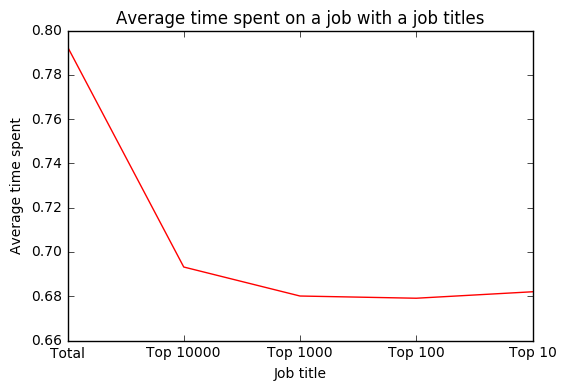

In [108]:
#graph to visualise time taken by user on job posting vis-a-vis popularity of company posting job
hello = [timetaken_jobtitle['time_taken'].mean(), timetaken_10000_jobtitle['time_taken'].mean(), timetaken_1000_jobtitle['time_taken'].mean(), timetaken_100_jobtitle['time_taken'].mean(), timetaken_10_jobtitle['time_taken'].mean()] 
hi = [1,2,3,4, 5]
label = ['Total', 'Top 10000', 'Top 1000',  'Top 100', 'Top 10']
plt.plot(hi, hello, 'r')
plt.xlabel('Job title')
plt.xticks(hi, label)
plt.ylabel('Average time spent')
plt.title("Average time spent on a job with a job titles")
plt.show() 
